# **Stochastic Differential Equations In Financial Modelling Coursework**

In [ ]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

# Question 1

An investor would be interested in holding this payoff if they are strongly confident that the stock will drop below $K_2$. This may be more preferable to hold over a put option due to its lower cost -- we reduce the price by selling a call option to finance the put. But this comes at the cost of accepting the reversal risk. If the stock goes against the expectations of the investor and exceeds the level $K_1$, the investor will receive a negative payoff. In theory, the investor could lose an infinite amount while in a put option, their maximum loss would just be the price of the put. Therefore, the investor should also expect the stock not to rise above $K_1$.


In [ ]:
# Parameters
s_0 = 100
K_1, K_2 = 105, 95
mu = 0.1
sigma = 0.4
r = 0.05
T = 10

## Question 2

To price the risk reversal, we need the price of an (out-of-the-money) put with strike $K_2$ and maturity $T$ minus the price of an (out-of-the-money) call with strike $K_1$ and maturity $T$, with both prices in the Black-Scholes model. Indeed, under the risk-neutral measure $\mathbb{Q}$:

\begin{align*}
V_{SRR}(0) &= \mathbb{E}^{\mathbb{Q}}_0 \big[e^{-rT}\big(-(S_T - K_1)^+ + (K_2 - S_T)^+ \big) \big] \\
&= \mathbb{E}^{\mathbb{Q}}_0 \big[e^{-rT}(K_2 - S_T)^+  \big] -\mathbb{E}^{\mathbb{Q}} \big[e^{-rT}(S_T - K_1)^+ \big] \\
&= V_{PUT}(0, K_2) - V_{CALL}(0, K_1)
\end{align*}

In [ ]:
# Calculate price of the short risk reversal at time t with Black-Scholes

def SRR_price(t, S_t, sigma):
    """
    Calculate short risk reversal price at time t under the Black-Scholes model with given volatility.

    Parameters:
    t (float or int): time between 0 and T
    S_t (float or array): stock price(s) at time t
    sigma (float): volatility

    Returns:
    float: price of SRR at time t
    """

    d1_call = (np.log(S_t / K_1) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * (T - t)**0.5)
    d1_put = (np.log(S_t / K_2) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * (T - t)**0.5)

    call_price = S_t * norm.cdf(d1_call) - K_1 * np.exp(-r * (T-t)) * norm.cdf(d1_call - sigma * (T-t)**0.5)
    put_price = -S_t * norm.cdf(-d1_put) + K_2 * np.exp(-r * (T-t)) * norm.cdf(-d1_put + sigma * (T-t)**0.5)

    v_t = put_price - call_price  # buy put, sell call
    return v_t

srr_price = SRR_price(0, s_0, sigma)
print(f"Price of the short risk reversal at t=0: {srr_price}")

Price of the short risk reversal at t=0: -39.91456225660142


The initial cost of this option is negative as the call option is more expensive than the put option. So an investor would actually receive money by setting up this payoff.

## Questions 3/4

We first simulate $n=10000$ possible realisations of the stock price at time $H=1$ using a geometric Brownian motion model. We then calculate the prices of the call and put at time $H$ by the Black-Scholes formula, which we then use to find the value of the short risk reversal strategy at time $H$. Using this, we can calculate $n$ potential losses of the strategy, from which we compute our risk measures.

- The VaR is calculated as the loss at the given confidence level i.e. the loss that will not be exceeded with a probability equal to the confidence level ($\mathbb{P}(L_H < \text{VaR}_{H,\alpha}) = \alpha$).
- The ES is calculated as the mean of losses given that the loss is beyond the VaR.

In [ ]:
# Calculate VaR and ES

def calculate_bear_risk_reversal_metrics(sigma, H, confidence=0.95, n=10000):
    """
    Calculate VaR and ES at 95% confidence of a short risk reversal with volatility sigma, and maturity T
    """
    # Simulate stock up to time H (vectorised)
    Z_t = np.random.normal(0, 1, n)
    S_H = s_0 * np.exp((mu - 0.5 * sigma**2) * H + Z_t * sigma * (H**0.5))

    # Compute the price at t=0 and t=H
    v_0 = SRR_price(0, s_0, sigma) # price at time 0
    v_H = SRR_price(H, S_H, sigma) # array of prices based on each simulation

    # Loss calculation
    potential_losses = sorted(v_0 - v_H)

    # Extracting VaR at the right confidence level from the loss
    var_index = round(confidence * n)
    var = potential_losses[var_index]

    # Calculating ES
    ES = np.mean(potential_losses[math.floor(confidence * n):n])

    return potential_losses, var, ES


# Histogram of the loss
def loss_histogram(ax, potential_losses, var, ES, vol):
    ax.hist(potential_losses, bins=100)
    ax.set(xlabel="Loss", ylabel="Frequency", title=rf"Histogram of the loss at $\sigma$ = {vol}")
    ax.axvline(x=var, color="r", linestyle="--", label=rf"$VaR_{{0.95}} = $ {var:.4f}")
    ax.axvline(x=ES, color="g", linestyle="--", label=f"ES = {ES:.4f}")
    ax.legend()

VaR: 91.40742116483725
ES: 129.7200349805439


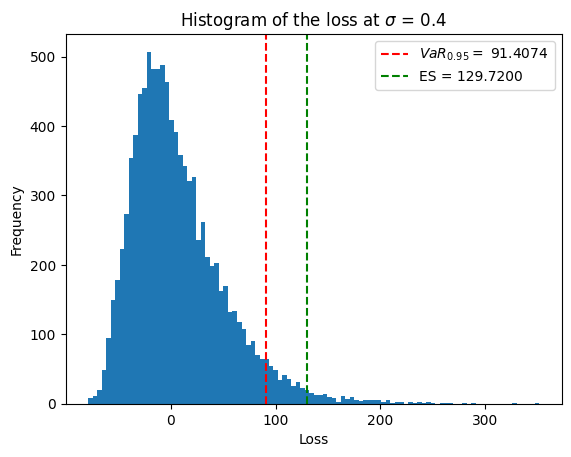

In [ ]:
sigma = 0.4
H = 1

potential_losses, var, ES = calculate_bear_risk_reversal_metrics(sigma, H)
fig, ax = plt.subplots()

print("VaR:", var)
print("ES:", ES)
loss_histogram(ax, potential_losses, var, ES, sigma)

## Question 5

We repeat the above for the given range of volatilities to see how the loss histogram and risk measures change with volatility.

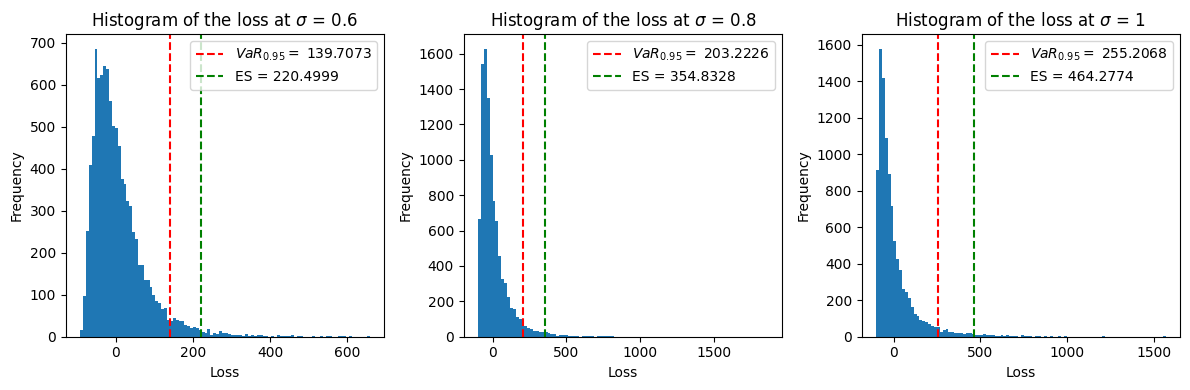


Volatility | VaR      | ES
-----------------------------
       0.6 | 139.7073 | 220.4999
       0.8 | 203.2226 | 354.8328
         1 | 255.2068 | 464.2774


In [ ]:
volatilities = [0.6, 0.8, 1]
var_array = np.zeros_like(volatilities)
ES_array = np.zeros_like(volatilities)
fig, axs = plt.subplots(1, len(volatilities), figsize=(12, 4))

for i, vol in enumerate(volatilities):
    potential_losses, var, ES = calculate_bear_risk_reversal_metrics(vol, H)
    loss_histogram(axs[i], potential_losses, var, ES, vol)
    var_array[i], ES_array[i] = var, ES  # store risk measures

plt.tight_layout()
plt.show()

print("\nVolatility | VaR      | ES")
print("-----------------------------")
for vol, var, es in zip(volatilities, var_array, ES_array):
    print(f"{vol:10} | {var:.4f} | {es:.4f}")

## Question 6


As we increase the volatility, it is clear to see that our risk measures increase. This is because the stock is more likely to significantly vary in both directions. This ultimately leads to greater potential losses because of the assymmetry in our payoff. We are bounded in the negative direction by $S_t > 0$ as we are in the Black-Scholes model so our potential gain is only finite. In the opposite direction, the stock can grow infinitely and so from the payoff graph, it is clear that we are exposed to potentially infinite losses. This idea is shown in the histograms above as our left tail seems to completely disappear -- our potential profit (or negative loss) is only finite.

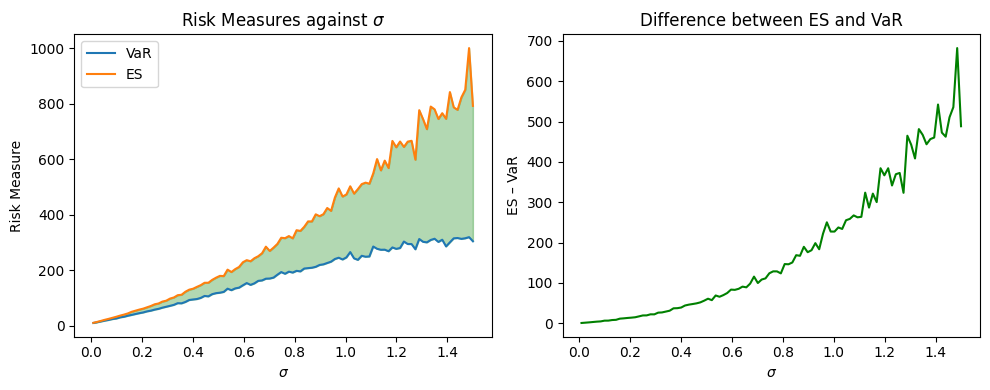

In [ ]:
volatilities = np.linspace(0.01, 1.5, 100)
var_array, ES_array = np.zeros_like(volatilities), np.zeros_like(volatilities)

for i, vol in enumerate(volatilities):
    _, var, ES = calculate_bear_risk_reversal_metrics(vol, H)
    var_array[i] = var
    ES_array[i] = ES

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(volatilities, var_array, label="VaR")
axs[0].plot(volatilities, ES_array, label="ES")
axs[0].fill_between(volatilities, ES_array, var_array, color="green", alpha=0.3)
axs[0].set(title=r"Risk Measures against $\sigma$", xlabel=r"$\sigma$", ylabel="Risk Measure")
axs[0].legend()

axs[1].plot(volatilities, ES_array - var_array, color="green")
axs[1].set(title=r"Difference between ES and VaR", xlabel=r"$\sigma$", ylabel=r"ES – VaR")

plt.tight_layout()
plt.show()

Note that as we increase the volatility $\sigma$, the difference between the ES and VaR, plotted above, increases. The potential losses in the tail end are increasing faster than the losses at the VaR threshold. We can deduce that the right tail of the loss distribution is becoming elongated (it is getting deeper).

We may also turn to the greeks to see how stock volatility can affect this option. In particular, Vega $\nu$ is the sensitivity to volatility.

\begin{align*}
\nu_0 = \frac{\partial V_{SRR}(0)}{\partial \sigma} &= \frac{\partial V_{PUT}(0, K_2)}{\partial \sigma} - \frac{\partial V_{CALL}(0, K_2)}{\partial \sigma} \\
&= S_0 \sqrt{T} \phi (d_1^2) - S_0 \sqrt{T} \phi (d_1^1) \\
&= S_0 \sqrt{T} (\phi (d_1^2) - \phi (d_1^1))
\end{align*}

where:

$$
d_1^i = \frac{log(\frac{S_0}{K_i}) - (r + \frac{1}{2} \sigma^2) T}{\sigma \sqrt{T}}
$$

We know that $K_1$ < $K_2$ so we proceed numerically to show that $\nu_0$ is negative.

In [ ]:
def calculate_vega(vol):
    d1_call = (np.log(s_0 / K_1) + (r + 0.5 * vol**2) * T) / (vol * T**0.5)  # redefining d1 for put and call
    d1_put = (np.log(s_0 / K_2) + (r + 0.5 * vol**2) * T) / (vol * T**0.5)
    vega = s_0 * np.sqrt(T) * (norm.pdf(d1_put) - norm.pdf(d1_call))
    return vega

Vega at t=0 for volatility = 0.4: -6.046305095631999 



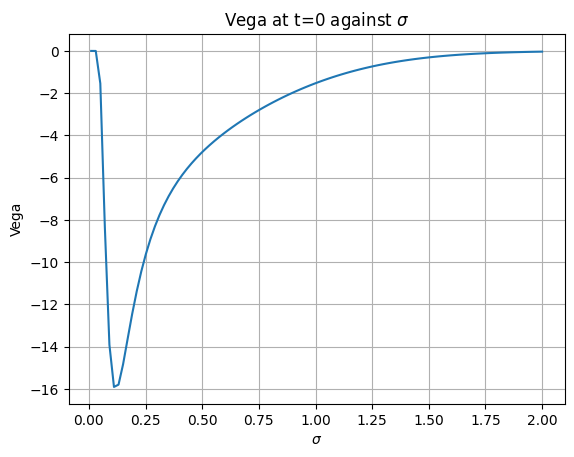

In [ ]:
print(f"Vega at t=0 for volatility = 0.4: {calculate_vega(0.4)} \n")

volatilities = np.linspace(0.01, 2, 100)
vega_array = [calculate_vega(vol) for vol in volatilities]
plt.plot(volatilities, vega_array)
#plt.hlines(0, 0, 2, linestyles='--', colors='r')
plt.xlabel(r"$\sigma$")
plt.ylabel("Vega")
plt.grid()
plt.title(r"Vega at t=0 against $\sigma$");

We note that Vega $\nu$ is negative at $t=0$ for all positive volatilities. This indicates that as volatility increases, the value of the option decreases. It is an indicator in the option becoming worthless as huge losses are on the horizon. This could also have been seen by plotting the value of the call option against volatility -- this would be a decreasing curve.